In [2]:
xmlPath = "/home/mickey/Documents/Theotime/DimaERC2/neuroencoders_1021/_test/test_small_file/amplifier.xml"
xmlPath = "/home/mickey/Documents/Theotime/DimaERC2/neuroencoders_1021/_work/M1199_PAG/amplifier.xml"
jsonPath = None
windowSizeMS = 108
mode = "ann"
target = "LinAndDirection"
nameExp = "LinAndDirection_NoSpecificLoss"
phase = "pre"


import os
import matplotlib.pyplot as plt

# Load standard libs
import sys
import pandas as pd

# Load custom code
sys.path.append(os.path.dirname((os.getcwd())))
from utils.global_classes import Params, Project, save_project_to_pickle
from importData import rawdata_parser
from resultAnalysis import print_results
from transformData.linearizer import UMazeLinearizer
from utils import management
from fullEncoder import an_network as Training
from importData.juliaData.julia_data_parser import julia_spike_filter
from openEphysExport.generate_json import generate_json
import numpy as np

deviceName = management.manage_devices("GPU")
ProjectPath = Project.load(
    os.path.join(os.path.dirname(xmlPath), nameExp, f"Project_{windowSizeMS}.pkl")
)
DataHelper = rawdata_parser.DataHelper(
    ProjectPath,
    mode=mode,
    target=target,
    phase=phase,
)
Parameters = Params(
    helper=DataHelper,
    windowSize=windowSizeMS / 1000,
    nEpochs=10,
    batchSize=256,
)
Linearizer = UMazeLinearizer(ProjectPath.folder)
folderCode = (
    os.path.dirname(os.path.realpath(os.path.dirname(os.getcwd()))) + os.path.sep
)
windowStride = 0.036
strideFactor = round(windowSizeMS / 1000 / windowStride, 4)

# Create linearization function
Linearizer = UMazeLinearizer(ProjectPath.folder)
Linearizer.verify_linearization(
    DataHelper.positions / DataHelper.maxPos(),
    ProjectPath.folder,
    overwrite=False,
)
l_function = Linearizer.pykeops_linearization

Linearization points have been created before


/home/mickey/Documents/Theotime/neuroEncoders/.venv/lib/python3.10/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'behavior'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)


In [3]:
positions = DataHelper.get_true_target(l_function, show=False, in_place=True)

In [4]:
import gui_elements
from importlib import reload

reload(gui_elements)
plotter = gui_elements.AnimatedPositionPlotter(DataHelper)
plotter.setup_plot(with_ref_bg=True)
plotter.show(interval=10)

Jupyter environment detected
Current backend: Qt5Agg
Using Qt5Agg backend for Jupyter
Jupyter environment detected
Current backend: Qt5Agg
Using Qt5Agg backend for Jupyter
Binary direction data detected (0s and 1s)
0 (shock zone) -> hotpink
1 (safe zone) -> cornflowerblue
Jupyter detected - using non-blocking display


In [5]:
%matplotlib inline

In [7]:
NNTrainer = Training.LSTMandSpikeNetwork(
    ProjectPath,
    Parameters,
    deviceName=deviceName,
    debug=False,
    phase=phase,
)

myoutputPos = KerasTensor(type_spec=TensorSpec(shape=(256, 2), dtype=tf.float32, name=None), name='feature_output/clip_by_value:0', description="created by layer 'feature_output'")
Loss function: <keras.src.losses.MeanSquaredLogarithmicError object at 0x7cd32832a410>


In [8]:
DataHelper.resultsPath

'/media/mickey/DataTheotime210/DimaERC2/neuroencoders_1021/_work/M1199_PAG/LinAndDirection_NoSpecificLoss/results/108'

In [15]:
featurePred = pd.read_csv(
    os.path.join(DataHelper.resultsPath, f"featurePred_{phase}.csv")
).to_numpy()
featureTrue = pd.read_csv(
    os.path.join(DataHelper.resultsPath, f"featureTrue_{phase}.csv")
).to_numpy()
lossPred = pd.read_csv(
    os.path.join(DataHelper.resultsPath, f"lossPred_{phase}.csv")
).to_numpy()

linearPred = pd.read_csv(
    os.path.join(DataHelper.resultsPath, f"linearPred_{phase}.csv")
).to_numpy()
linearTrue = pd.read_csv(
    os.path.join(DataHelper.resultsPath, f"linearTrue_{phase}.csv")
).to_numpy()

In [51]:
featurePred = featurePred[:, -2]
featureTrue = featureTrue[:, -2]
lossPred = lossPred[:, -1]

In [54]:
qControl

0.39

In [74]:
qControltmp = lossPred.copy()
temp = lossPred.argsort(axis=0)

In [77]:
thresh = np.squeeze(qControltmp[temp[int(len(temp) * 0.5)]])

In [79]:
np.quantile(lossPred, 0.5)

0.043841780999999996

In [82]:
selection = np.squeeze(qControltmp < thresh)

In [84]:
inferring = featurePred
pos = featureTrue

In [83]:
selection

array([False, False, False, ..., False, False,  True])

In [71]:
temp

array([ 8379,  3123,  8378, ...,   534,  5226, 10482])

In [56]:
%matplotlib inline

In [58]:
lossPred

array([0.06599298, 0.05257418, 0.04648157, ..., 0.04816256, 0.055629  ,
       0.03982912])

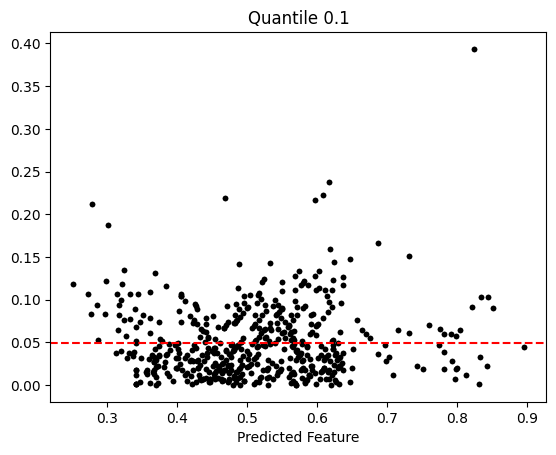

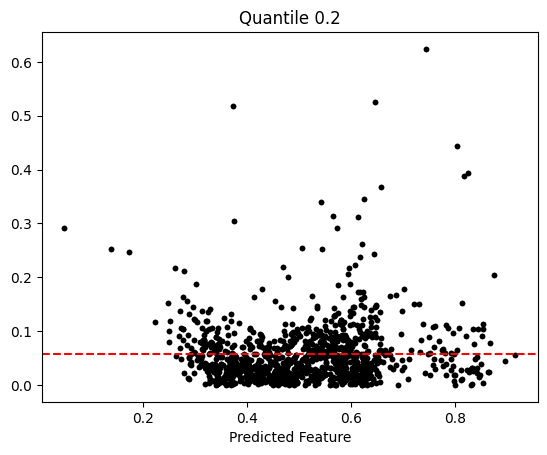

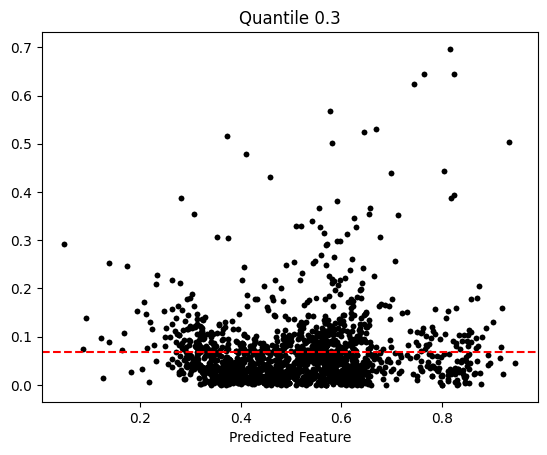

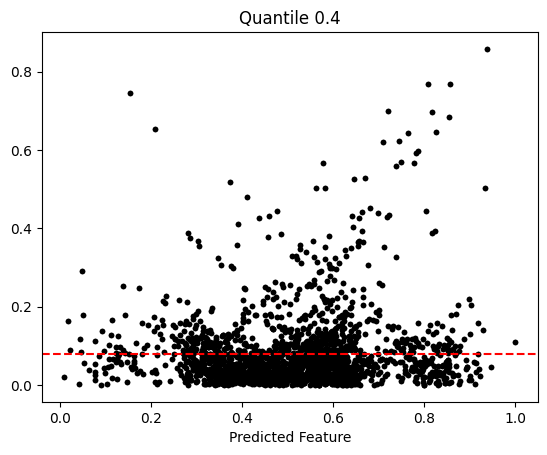

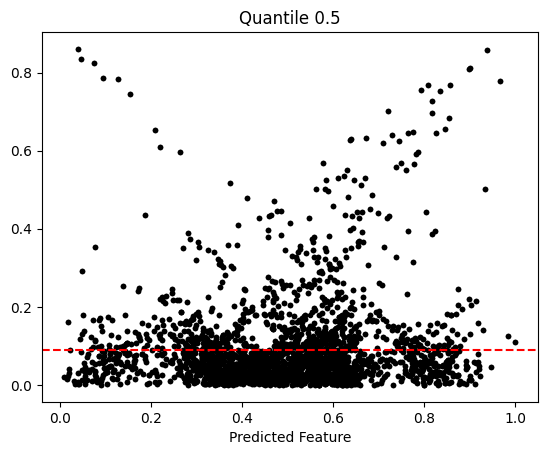

In [65]:
for quantile in [0.1, 0.2, 0.3, 0.4, 0.5]:
    qControl = np.quantile(lossPred, quantile)
    plt.figure()
    plt.title(f"Quantile {quantile}")
    plt.plot(
        featurePred[lossPred < qControl],
        np.abs(featureTrue[lossPred < qControl] - featurePred[lossPred < qControl]),
        "k.",
    )
    mean_error = np.mean(
        np.abs(featureTrue[lossPred < qControl] - featurePred[lossPred < qControl])
    )
    plt.axhline(
        mean_error, color="r", linestyle="--", label=f"Mean Error: {mean_error:.2f}"
    )
    plt.xlabel("Predicted Feature")

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(
    featurePred["time"],
    featurePred["position"],
    label="Predicted Position",
    color="blue",
)

In [ ]:
print_results.print_results(
    "/home/mickey/Documents/Theotime/DimaERC2/neuroencoders_1021/_work/M1199_PAG/LinAndDirection_NoSpecificLoss/results/",
    windowSizeMS=108,
    lossSelection=0.5,
    target="LinAndDirection",
)

total windows: 10496 | selected windows: 5248 (thresh 0.04384352  ( 50.0 %) )
mean eucl. error: 0.4765659181693496 | selected error: 0.43182998796134725
mean linear error: 0.13269837010705984 | selected error: 0.0899117534691311


: 

In [30]:
self = NNTrainer
behaviorData = DataHelper.fullBehavior
windowSizeMS
useSpeedFilter = False
import tensorflow as tf


def parse_serialized_spike(featDesc, ex_proto, batched=False):
    if batched:
        tensors = tf.io.parse_example(serialized=ex_proto, features=featDesc)
    else:
        tensors = tf.io.parse_single_example(serialized=ex_proto, features=featDesc)
    return tensors


def _parse_function(*vals):
    return parse_serialized_spike(self.featDesc, *vals)

In [31]:
speedMask = behaviorData["Times"]["speedFilter"]

## Get datasets
ndataset = tf.data.TFRecordDataset(
    os.path.join(
        self.projectPath.dataPath,
        ("dataset" + "_stride" + str(windowSizeMS) + ".tfrec"),
    )
)

In [32]:
ndataset = ndataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

In [37]:
from epochs_management import inEpochsMask

epochMask = {}
totMask = {}

epochMask["train"] = inEpochsMask(
    behaviorData["positionTime"][:, 0], behaviorData["Times"]["trainEpochs"]
)
epochMask["test"] = inEpochsMask(
    behaviorData["positionTime"][:, 0], behaviorData["Times"]["testEpochs"]
)
if len(behaviorData["Times"]["lossPredSetEpochs"]) > 0 and isPredLoss:
    epochMask["predLoss"] = inEpochsMask(
        behaviorData["positionTime"][:, 0],
        behaviorData["Times"]["lossPredSetEpochs"],
    )
for key in epochMask.keys():
    totMask[key] = speedMask * epochMask[key]

# Create datasets
datasets = {}

In [46]:
def parse_serialized_sequence(params, tensors, batched=False):  # featDesc, ex_proto,
    tensors["groups"] = tf.sparse.to_dense(tensors["groups"], default_value=-1)
    # Pierre 13/02/2021: Why use sparse.to_dense, and not directly a FixedLenFeature?
    # Probably because he wanted a variable length <> inputs sequences
    tensors["groups"] = tf.reshape(tensors["groups"], [-1])

    tensors["indexInDat"] = tf.sparse.to_dense(tensors["indexInDat"], default_value=-1)
    tensors["indexInDat"] = tf.reshape(tensors["indexInDat"], [-1])

    for g in range(params.nGroups):
        # here 32 correspond to the number of discretized time bin for a spike
        zeros = tf.constant(np.zeros([params.nChannelsPerGroup[g], 32]), tf.float32)
        tensors["group" + str(g)] = tf.sparse.reshape(tensors["group" + str(g)], [-1])
        tensors["group" + str(g)] = tf.sparse.to_dense(tensors["group" + str(g)])
        tensors["group" + str(g)] = tf.reshape(tensors["group" + str(g)], [-1])
        if batched:
            tensors["group" + str(g)] = tf.reshape(
                tensors["group" + str(g)],
                [params.batchSize, -1, params.nChannelsPerGroup[g], 32],
            )
        # even if batched: gather all together
        tensors["group" + str(g)] = tf.reshape(
            tensors["group" + str(g)], [-1, params.nChannelsPerGroup[g], 32]
        )
        # Pierre 12/03/2021: the batchSize and timesteps are gathered together
        nonZeros = tf.logical_not(
            tf.equal(
                tf.reduce_sum(
                    input_tensor=tf.cast(
                        tf.equal(tensors["group" + str(g)], zeros), tf.int32
                    ),
                    axis=[1, 2],
                ),
                32 * params.nChannelsPerGroup[g],
            )
        )
        # nonZeros: control that the voltage measured is not 0, at all channels and time bin inside the detected spike
        tensors["group" + str(g)] = tf.gather(
            tensors["group" + str(g)], tf.where(nonZeros)
        )[:, 0, :, :]
        # I don't understand why it can then call [:,0,:,:] as the output tensor of gather should have the same
        # shape as tensors["group"+str(g)"], [-1,params.nChannels[g],32] ...

    return tensors


def filter_by_pos_index(x):
    return tf.equal(table.lookup(x["pos_index"]), 1.0)


def nnUtils_import_true_pos(feature):
    def change_feature(vals):
        vals["pos"] = tf.gather(feature, vals["pos_index"])
        return vals

    return change_feature


# TODO: delete
def import_true_pos(x):
    return nnUtils_import_true_pos(posFeature)(x)


def filter_nan_pos(x):
    return tf.math.logical_not(tf.math.is_nan(tf.math.reduce_sum(x["pos"])))


def map_parse_serialized_sequence(*vals):
    return parse_serialized_sequence(self.params, *vals, batched=True)


def map_outputs(vals):
    return (
        vals,
        {
            self.outNames[0]: tf.zeros(self.params.batchSize),
            self.outNames[1]: tf.zeros(self.params.batchSize),
        },
    )

In [57]:
key = "train"

table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        tf.constant(np.arange(len(totMask[key])), dtype=tf.int64),
        tf.constant(totMask[key], dtype=tf.float64),
    ),
    default_value=0,
)
datasets[key] = ndataset.filter(filter_by_pos_index)
# This is just max normalization to use if the behavioral data have not been normalized yet
# TODO: make a way to input 1D target, different 2D targets...
# coherent with the --target arg from main
if False:
    maxPos = np.nanmax(
        behaviorData["Positions"][
            np.logical_not(np.isnan(np.sum(behaviorData["Positions"], axis=1)))
        ]
    )
    posFeature = behaviorData["Positions"] / maxPos
else:
    posFeature = behaviorData["Positions"]
datasets[key] = datasets[key].map(nnUtils_import_true_pos(posFeature))
datasets[key] = datasets[key].filter(filter_nan_pos)
datasets[key] = datasets[key].batch(self.params.batchSize, drop_remainder=True)

datasets[key] = datasets[key].map(
    map_parse_serialized_sequence, num_parallel_calls=tf.data.AUTOTUNE
)  # self.featDesc, *
# We then reorganize the dataset so that it provides (inputsDict,outputsDict) tuple
# for now we provide all inputs as potential outputs targets... but this can be changed in the future...
datasets[key] = datasets[key].map(
    self.create_indices, num_parallel_calls=tf.data.AUTOTUNE
)


datasets[key] = datasets[key].map(map_outputs, num_parallel_calls=tf.data.AUTOTUNE)
# We shuffle the datasets and cache it - this way the training samples are randomized for each epoch
# and each mini-batch contains a representative sample of the training set.
# nSteps represent the buffer size of the shuffle operation - 10 seconds worth of buffer starting
# from the 0-timepoint of the dataset.
# once an element is selected, its space in the buffer is replaced by the next element (right after the 10s window...)
# At each epoch, the shuffle order is different.

datasets[key] = (
    datasets[key]
    .shuffle(
        self.params.nSteps, reshuffle_each_iteration=True
    )  # NOTE: nSteps = int(10000 * 0.036 / windowSize), 10s worth of buffer
    .cache()
)  # .repeat() #
datasets[key] = datasets[key].cache()

In [79]:
datasets[key] = datasets[key].cache()

In [82]:
for i, first in enumerate(datasets[key]):
    if i == 1:
        break

first = first[0]

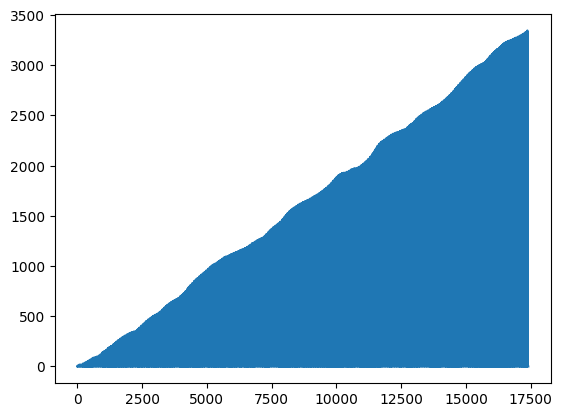

In [83]:
plt.plot(first["indices0"].numpy())